<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/hands-on-generative-ai-with-transformers-and-diffusion-models/01_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%%capture

!pip install genaibook

In [36]:
from datasets import load_dataset

import torch
import torchsummary
from torch import nn
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader

import matplotlib as mpl
from matplotlib import pyplot as plt

from genaibook.core import show_images
from genaibook.core import get_device

from tqdm.notebook import tqdm, trange

import pandas as pd

## Dataset

In [ ]:
mnist = load_dataset("mnist")

In [4]:
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [5]:
mnist["train"]["image"][1]

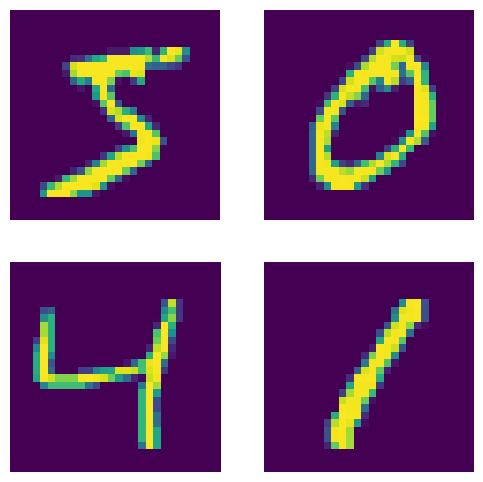

In [6]:
# let's show them with higher resolution
show_images(mnist["train"]["image"][:4])

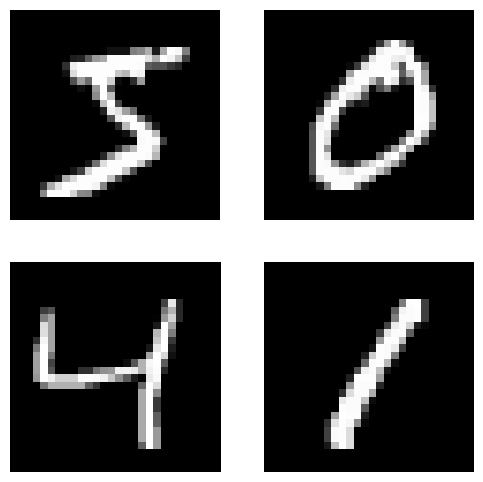

In [7]:
# let's configure matplotlib to just use gray colors instead
mpl.rcParams["image.cmap"] = "gray"
show_images(mnist["train"]["image"][:4])

In [8]:
torch.manual_seed(1337);

# let's convert the images to PyTorch tensors and shuffle the training dataset
def mnist_to_tensor(example):
  t = transforms.ToTensor()
  example["image"] = [t(img) for img in example["image"]]
  return example

mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [9]:
# Let’s check out a single image from the dataset
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

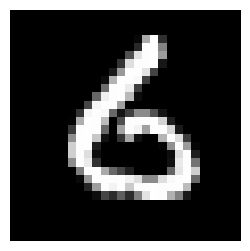

In [10]:
show_images([x])

In [11]:
# Let's now create a PyTorch DataLoader to prepare the training data
bs = 64
# just need image column of the dataset and ignore the labels
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

## Modeling Encoder

In [12]:
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [13]:
class Encoder(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.conv1 = conv_block(in_channels, 128)
    self.conv2 = conv_block(128, 256)
    self.conv3 = conv_block(256, 512)
    self.conv4 = conv_block(512, 1024)
    self.linear = nn.Linear(1024, 16)

  def forward(self, x):
    x = self.conv1(x) # (batch size, 128, 14, 14)
    x = self.conv2(x) # (bs, 256, 7, 7)
    x = self.conv3(x) # (bs, 512, 3, 3)
    x = self.conv4(x) # (bs, 1024, 1, 1)
    # Keep batch dimension when flattening
    x = self.linear(torch.flatten(x, start_dim=1)) # (bs, 16)
    return x

In [14]:
# Let’s verify that we can run our input images through the encoder
print(mnist["train"]["image"][0].shape)

torch.Size([1, 28, 28])


In [15]:
in_channels = 1

x = mnist["train"]["image"][0][None, :]

encoder = Encoder(in_channels).eval()
encoded_x = encoder(x)
encoded_x.shape

torch.Size([1, 16])

In [16]:
encoded_x

tensor([[-0.0145, -0.0318, -0.0109,  0.0080, -0.0218,  0.0305,  0.0183, -0.0294,
          0.0075,  0.0178, -0.0161, -0.0018,  0.0208, -0.0079,  0.0215,  0.0101]],
       grad_fn=<AddmmBackward0>)

In [17]:
# Let’s see if it can handle a batch of 64 images
batch = next(iter(train_dataloader))

encoded_batch = Encoder(in_channels=1)(batch)
batch.shape, encoded_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

## Modeling Decoder

In [18]:
def conv_transpose_block(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=0, with_act=True):
  models = [
      nn.ConvTranspose2d(
          in_channels,
          out_channels,
          kernel_size=kernel_size,
          stride=stride,
          padding=padding,
          output_padding=output_padding),
  ]
  if with_act:
    models.append(nn.BatchNorm2d(out_channels))
    models.append(nn.ReLU())
  return nn.Sequential(*models)

In [19]:
class Decoder(nn.Module):
  def __init__(self, out_channels):
    super().__init__()
    self.linear = nn.Linear(16, 1024 * 4 * 4)  # note it's reshaped in forward
    self.t_conv1 = conv_transpose_block(1024, 512)
    self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
    self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)

  def forward(self, x):
    bs = x.shape[0]
    x = self.linear(x)              # (bs, 1024*4*4)
    x = x.reshape(bs, 1024, 4, 4)   # (bs, 1024, 4, 4)
    x = self.t_conv1(x)             # (bs, 512, 7, 7)
    x = self.t_conv2(x)             # (bs, 256, 14, 14)
    x = self.t_conv3(x)             # (bs, 1, 28, 28)
    return x

In [20]:
decoded_batch = Decoder(x.shape[0])(encoded_batch)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

## Training

In [21]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.encoder = Encoder(in_channels)
    self.decoder = Decoder(in_channels)

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    return self.decode(self.encode(x))

In [22]:
model = AutoEncoder(in_channels=1)

In [23]:
torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [24]:
# Let’s get started on training
num_epochs = 10
lr = 1e-4
device = get_device()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-5)

losses = []
for _ in (progress:=trange(num_epochs, desc="Training")):
  for _, batch in (inner:=tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
    batch = batch.to(device)

    # Pass through the model and obtain reconstructed images
    preds = model(batch)

    # Compare the prediction with the original images
    loss = F.mse_loss(preds, batch)

    # Display loss and store for plotting
    inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
    losses.append(loss.item())

    # Update the model parameters with the optimizer based on this loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

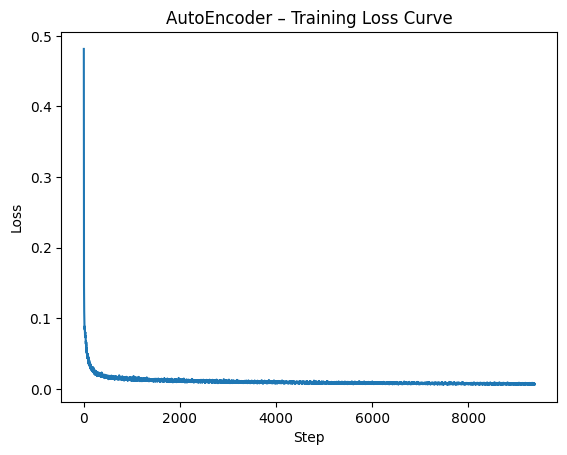

In [25]:
# Let’s plot the loss curve to see how the training went
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

In [26]:
# let's begin creating the evaluation DataLoader
eval_bs= 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

In [27]:
model.eval()
with torch.inference_mode():
  eval_batch = next(iter(eval_dataloader))
  predicted = model(eval_batch.to(device)).cpu()

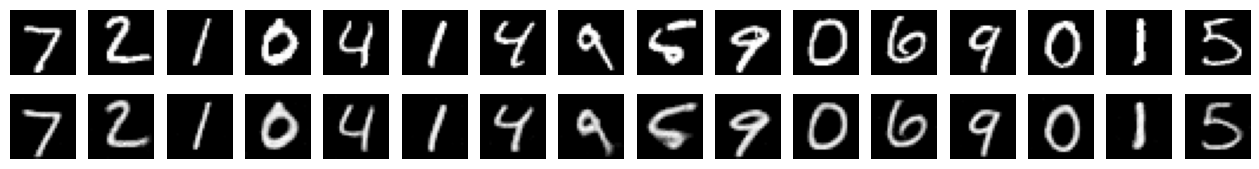

In [28]:
# let’s display the original images and their reconstructions
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

## Exploring the Latent Space

In [29]:
class Encoder(nn.Module):
  def __init__(self, in_channels, latent_dims):
    super().__init__()

    self.conv_layers = nn.Sequential(
      conv_block(in_channels, 128),
      conv_block(128, 256),
      conv_block(256, 512),
      conv_block(512, 1024),
    )

    self.linear = nn.Linear(1024, latent_dims)

  def forward(self, x):
    bs = x.shape[0]
    x = self.conv_layers(x)
    x = self.linear(x.reshape(bs, -1))
    return x

In [30]:
class Decoder(nn.Module):
  def __init__(self, out_channels, latent_dims):
    super().__init__()

    self.linear = nn.Linear(latent_dims, 1024 * 4 * 4)
    self.t_conv_layers = nn.Sequential(
      conv_transpose_block(1024, 512),
      conv_transpose_block(512, 256, output_padding=1),
      conv_transpose_block(256, out_channels, output_padding=1, with_act=False),
    )
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    bs = x.shape[0]
    x = self.linear(x)
    x = x.reshape(bs, 1024, 4, 4)
    x = self.t_conv_layers(x)
    x = self.sigmoid(x)
    return x

In [31]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels, latent_dims):
    super().__init__()
    self.encoder = Encoder(in_channels, latent_dims)
    self.decoder = Decoder(in_channels, latent_dims)

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    return self.decode(self.encode(x))

In [32]:
def train(model, num_epochs=10, lr=1e-4):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-5)

  model.train() # Put model in training mode
  losses = []
  for _ in (progress:=trange(num_epochs, desc="Training")):
    for _, batch in (inner:=tqdm(enumerate(train_dataloader), total=len(train_dataloader))):
      batch = batch.to(device)

      # Pass through the model and obtain another set of images
      preds = model(batch)

      # Compare the prediction with the original images
      loss = F.mse_loss(preds, batch)

      # Display loss and store for plotting
      inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
      losses.append(loss.item())

      # Update the model parameters with the optimizer based on this loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
  return losses

In [33]:
ae_model = AutoEncoder(in_channels=1, latent_dims=2)
ae_model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (linear): Linear(in_

In [34]:
losses = train(ae_model)

Training:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

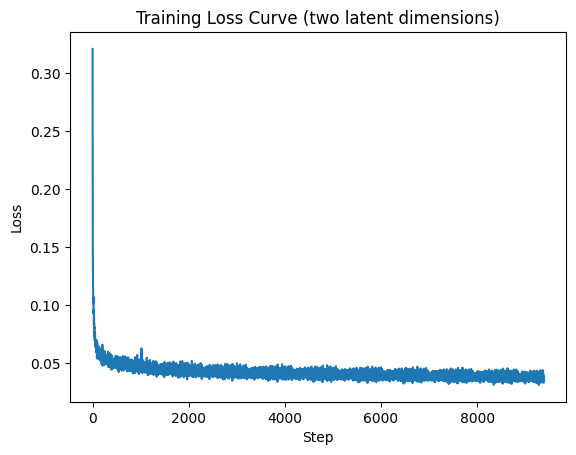

In [35]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve (two latent dimensions)")
plt.show()

In [37]:
# Let’s once again load the trained model and look at some reconstructions
model.eval()
with torch.inference_mode():
  eval_batch = next(iter(eval_dataloader))
  predicted = model(eval_batch.to(device)).cpu()

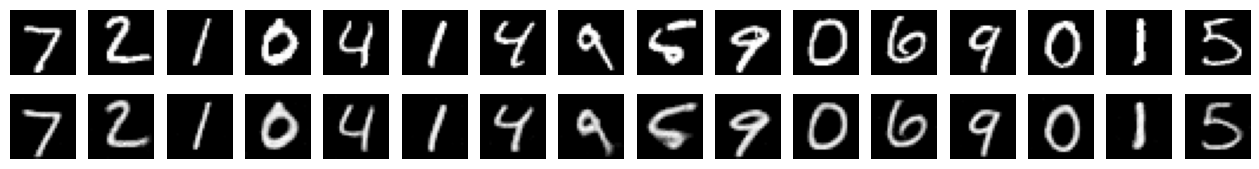

In [38]:
# let’s display the original images and their reconstructions
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

## Visualizing the Latent Space

Let’s now represent all the encoded vectors from the test dataset, using the label column to assign different colors to each class.

In [39]:
images_labels_dataloader = DataLoader(mnist["test"], batch_size=512)

In [40]:
df = pd.DataFrame({
    "x": [],
    "y": [],
    "label": []
})

for _, batch in tqdm(enumerate(images_labels_dataloader), total=len(images_labels_dataloader)):
  encoded = ae_model.encode(batch["image"].to(device)).cpu()
  new_items = pd.DataFrame({
      "x": [t.item() for t in encoded[:, 0]],
      "y": [t.item() for t in encoded[:, 1]],
      "label": batch["label"]
  })
  df = pd.concat([df, pd.DataFrame(new_items)], ignore_index=True)

  0%|          | 0/20 [00:00<?, ?it/s]

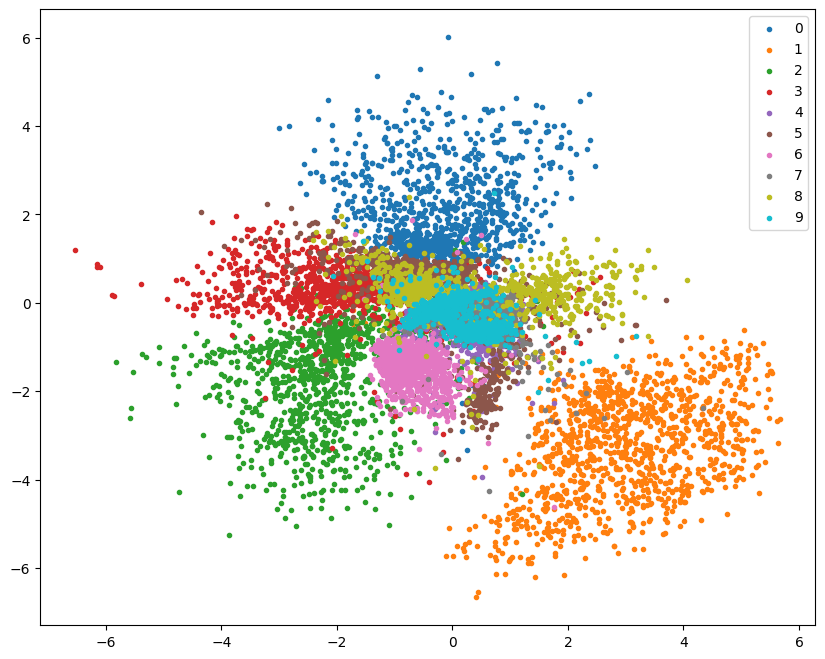

In [41]:
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.legend();

In [44]:
# Let’s see an example of image generation with the decoder
N = 16 # We'll generate 16 points
z = torch.rand((N, 2)) * 8 - 4

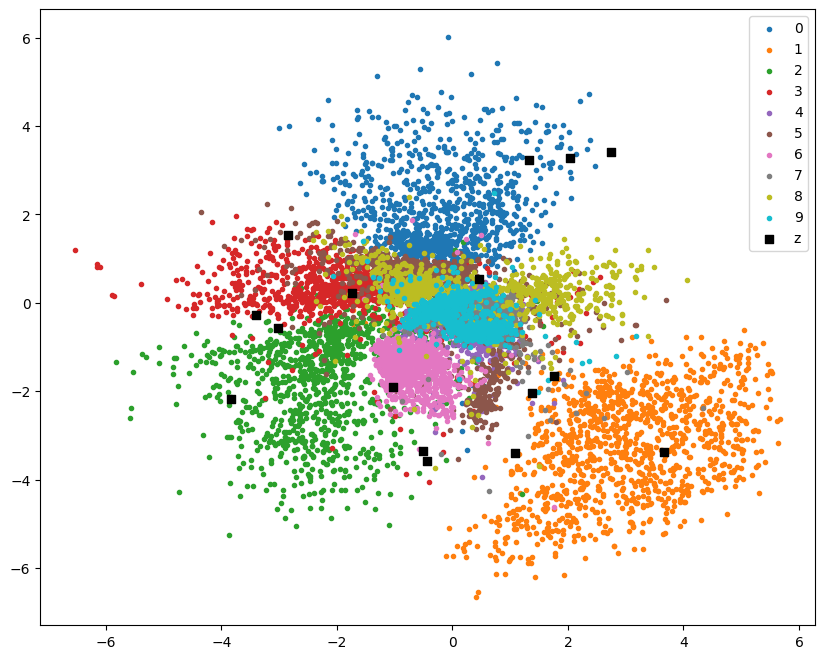

In [45]:
# Let’s visualize the generated latent samples overlayed on top of the latent space
plt.figure(figsize=(10, 8))

for label in range(10):
    points = df[df["label"] == label]
    plt.scatter(points["x"], points["y"], label=label, marker=".")

plt.scatter(z[:, 0], z[:, 1], label="z", color="black", marker="s")
plt.legend();

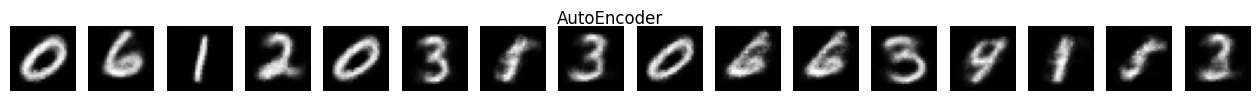

In [46]:
# Finally, let’s ask the decoder to generate images from the latent samples
ae_encoded = ae_model.decode(z.to(device)).cpu()
show_images(ae_encoded, imsize=1, nrows=1, suptitle="AutoEncoder")